In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import json # to convert json in df
from pandas.io.json import json_normalize # to normalize the json file
import ast
import random

import matplotlib.pyplot as plt
%matplotlib inline

import gc

import os

print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train_v2.csv', 'test_v2.csv', 'sample_submission_v2.csv']


In [2]:
%%time
# p is a fractional number to skiprows and read just a random sample of the our dataset. 
p = 0.1 
df_train = pd.read_csv("../input/train_v2.csv", sep=',', usecols=['hits'], nrows = 20000)
                       # converters={'hits':ast.literal_eval}, 
                       #skiprows=lambda i: i>0 and random.random() > p)
# converters={'hits':ast.literal_eval}

CPU times: user 2.73 s, sys: 1.46 s, total: 4.19 s
Wall time: 4.24 s


In [4]:
%%time
df_test = pd.read_csv("../input/train_v2.csv", sep=',', usecols=['hits'], nrows = 10000)

CPU times: user 1.93 s, sys: 556 ms, total: 2.49 s
Wall time: 2.48 s


In [5]:
from multiprocessing import Pool as Pool
import functools

def apply_func_on_series(data=None, func=None):
    return data.apply(lambda x: func(x))

def multi_apply_func_on_series(df=None, func=None, n_jobs=4):
    p = Pool(n_jobs)
    f_ = p.map(functools.partial(apply_func_on_series, func=func),
               np.array_split(df, n_jobs))
    f_ = pd.concat(f_, axis=0, ignore_index=True)
    p.close()
    p.join()
    return f_.values

In [7]:
%%time
# df_train['hits_ast'] =  apply_func_on_series(
#             df=df_train['hits'],
#             func=ast.literal_eval)
gc.collect()
df_train['hits'] =  multi_apply_func_on_series(
            df=df_train['hits'],
            func=ast.literal_eval,
            n_jobs=4
        )

CPU times: user 11.3 s, sys: 3 s, total: 14.3 s
Wall time: 55 s


In [8]:
%%time
df_test['hits'] =  multi_apply_func_on_series(
            df=df_test['hits'],
            func=ast.literal_eval,
            n_jobs=4
        )

CPU times: user 10.4 s, sys: 3.46 s, total: 13.9 s
Wall time: 48 s


In [13]:
%%time
df_train['hits.times'] = df_train['hits'].apply(lambda x: len(x))
df_test['hits.times'] = df_test['hits'].apply(lambda x: len(x))

CPU times: user 48 ms, sys: 0 ns, total: 48 ms
Wall time: 48.2 ms


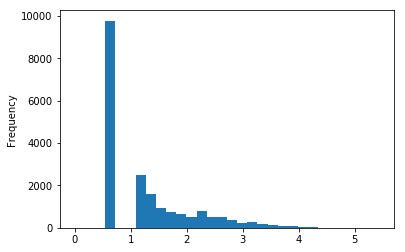

In [12]:
# print(df_train['len'].value_counts())
# plt.hist(df_train['len'], normed=True, bins=30)
np.log(df_train['hits.times'] + 1).plot.hist(bins=30)
plt.show()

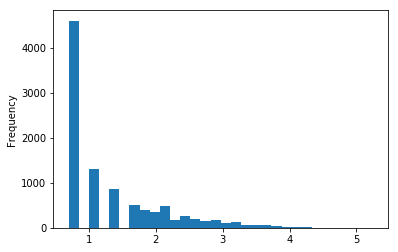

In [14]:
np.log(df_test['hits.times'] + 1).plot.hist(bins=30)
plt.show()

In [15]:
sum(df_train['hits.times'] == 0)

6

In [16]:
df_train[['hits.times', 'hits']].head()

,hits.times,hits
0,1,"[{'hitNumber': '1', 'time': '0', 'hour': '17',..."
1,2,"[{'hitNumber': '1', 'time': '0', 'hour': '10',..."
2,2,"[{'hitNumber': '1', 'time': '0', 'hour': '17',..."
3,2,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ..."
4,2,"[{'hitNumber': '1', 'time': '0', 'hour': '14',..."


In [17]:
print(df_train['hits.times'].max())
hits_train = df_train.loc[df_train['hits.times'].idxmax(), 'hits']
keys = set()
for h in hits_train[0:20]:
    keys.update(set(h.keys()))
print(len(keys), keys)

229
24 {'social', 'type', 'eventInfo', 'referer', 'exceptionInfo', 'promotion', 'customDimensions', 'page', 'contentGroup', 'transaction', 'hour', 'experiment', 'minute', 'appInfo', 'customVariables', 'item', 'publisher_infos', 'customMetrics', 'eCommerceAction', 'time', 'hitNumber', 'product', 'isEntrance', 'isInteraction'}


In [18]:
print(df_test['hits.times'].max())
hits_test = df_test.loc[df_test['hits.times'].idxmax(), 'hits']
keys_test = set()
for h in hits_test[0:20]:
    keys_test.update(set(h.keys()))
print(len(keys_test), keys_test)

189
25 {'social', 'type', 'eventInfo', 'referer', 'exceptionInfo', 'promotion', 'customDimensions', 'page', 'contentGroup', 'transaction', 'hour', 'experiment', 'minute', 'appInfo', 'customVariables', 'customMetrics', 'publisher_infos', 'item', 'eCommerceAction', 'time', 'hitNumber', 'product', 'isEntrance', 'promotionActionInfo', 'isInteraction'}


In [19]:
def func_hits(hits):
    df_hits = pd.DataFrame(hits)
    
    if 'promotion' in df_hits.columns:
        promotion = sum(df_hits['promotion'].apply(lambda x: True if len(x) > 0 else False))
    else:
        promotion = 0
        
    if 'promotionActionInfo' in df_hits.columns:
        promotionActionInfo = sum(~df_hits['promotionActionInfo'].isnull())    
    else:
        promotionActionInfo = 0

    if 'transaction' in df_hits.columns:
        transaction = sum(~df_hits['transaction'].isnull())    
    else:
        transaction = 0
        
    if 'eventInfo' in df_hits.columns:
        eventInfo = sum(~df_hits['eventInfo'].isnull())    
    else:
        eventInfo = 0
    
    return transaction, promotion, promotionActionInfo, eventInfo

In [ ]:
# print(sum(df_hits['promotion'].apply(lambda x: True if len(x) > 0 else False)))
# print(sum(~df_hits['promotionActionInfo'].isnull()))
# print(sum(~df_hits['eventInfo'].isnull()))
# print(sum(~df_hits['transaction'].isnull()))
# print(sum(df_hits['isInteraction']==True))
# print(sum(df_hits['isEntrance']==True))
# print(sum(df_hits['isExit']==True))

In [33]:
%%time
tmp = df_train.loc[:, 'hits']

#tmp['hit_nums'], tmp['promotion'], tmp['promotionActionInfo'] = zip(tmp.apply(lambda x: func_hits(x)))
out1 = pd.DataFrame(list(tmp.apply(lambda x: func_hits(x))), 
                    columns = ['transaction',
                               'promotion', 'promotionActionInfo',
                              'eventInfo'])

del tmp
gc.collect()

# tmp.join(out1)
# print(tmp)
#pd.DataFrame(tmp['hits_ast'][0])
#func_hits(tmp['hits_ast'][0])

CPU times: user 1min 5s, sys: 720 ms, total: 1min 6s
Wall time: 1min 5s


In [36]:
df_train = pd.concat([df_train, out1], axis = 1)
del out1
gc.collect()

73

In [38]:
%%time
tmp = df_test.loc[:, 'hits']

#tmp['hit_nums'], tmp['promotion'], tmp['promotionActionInfo'] = zip(tmp.apply(lambda x: func_hits(x)))
out1 = pd.DataFrame(list(tmp.apply(lambda x: func_hits(x))), 
                    columns = ['transaction',
                               'promotion', 'promotionActionInfo',
                              'eventInfo'])

del tmp
gc.collect()

df_test = pd.concat([df_test, out1], axis = 1)
del out1
gc.collect()

CPU times: user 39.1 s, sys: 396 ms, total: 39.5 s
Wall time: 39.1 s


In [39]:
df_test.head()

,hits,hits.times,transaction,promotion,promotionActionInfo,eventInfo
0,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1,1,0,0,0
1,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",2,1,1,1,0
2,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",2,1,1,1,0
3,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",2,1,1,1,0
4,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",2,1,1,1,0


In [40]:
df_train = df_train.drop('hits', axis = 1)
df_test = df_test.drop('hits', axis = 1)

In [ ]:
df_train.to_csv('train_hits.csv', sep=',')
df_test.to_csv('test_hits.csv', sep=',')